### Setup

In [ ]:
import numpy as np
import gudhi
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def plot_persistence_barcode(persistence, ax = None):
    '''
    Parametros:
    ----------
    
    persistence: list of tuples (dimension, (birth, death))
    '''
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))

    bar_idx = 0
    for dim in sorted(set(d for d, _ in persistence)):
        intervals = [interval for d, interval in persistence if d == dim]
        for i, (birth, death) in enumerate(intervals):
            if death == float('inf'):
                death = max(birth + 1, 4)
            ax.plot([birth, death], [bar_idx, bar_idx], marker='', c=f'C{dim}', linewidth=2, label=f'Dim {dim}' if i==0  else "")
            # Markers at birth and death
            ax.plot(birth, bar_idx, marker='|', c=f'C{dim}')
            ax.plot(death, bar_idx, marker='4', c=f'C{dim}', markersize=5)
            bar_idx += 1

    ax.set_xlabel('Filtration Value')
    ax.set_ylabel('Barcode Index')
    ax.set_title('Barcode')
    ax.set_yticks([])
    x_vals = sorted([death for _, (_, death) in persistence if death != float('inf')])
    x_labels = [f'{x:.2f}' for x in x_vals] + ['∞']
    ax.set_xticks(x_vals + [max(x_vals) + 1], x_labels)
    if len(persistence) < 20:
        ax.set_ylim(-10/len(persistence), len(persistence)*2)
    ax.legend()

def plot_persistence(persistence, ax = None):
    '''
    Parametros:
    ----------
    
    persistence: list of tuples (dimension, (birth, death))
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    gudhi.plot_persistence_diagram(persistence, axes=ax[0])
    plot_persistence_barcode(persistence, ax=ax[1])

    ax[0].set_title("Persistence Diagram")
    ax[1].set_title("Barcode")

    plt.tight_layout()
    plt.show()

def add_edges_from_ids(G, ids, edges_ids, valid_edges):
    '''
    edges_ids: list of tuples (id1, id2)
    '''
    output = G.copy()
    for id1, id2 in edges_ids:
        for n1 in ids[id1]:
            for n2 in ids[id2]:
                if (n1, n2) in valid_edges or (n2, n1) in valid_edges:
                    output.add_edge(n1, n2)
    return output

def plot_triangles(triangles, ax, pos):
    for triangle in triangles:
        triangle_coords = [pos[node] for node in triangle]
        triangle_patch = Polygon(triangle_coords, fill=True, facecolor='gray', alpha=0.3)
        ax.add_patch(triangle_patch)


### Ejercicio 1
Generamos una matriz de distancias aleatoria y simétrica para 5 puntos.

In [2]:
np.random.seed(28)
D = np.random.randint(1, 4, size=(5, 5))
for i in range(5):
    for j in range(i, 5):
        if i == j:
            D[i, j] = 0
        else:
            d = max(D[i, j], D[j, i])
            D[i, j] = d
            D[j, i] = d
print(f'D =\n{D}')

D =
[[0 2 2 3 2]
 [2 0 1 1 1]
 [2 1 0 3 3]
 [3 1 3 0 3]
 [2 1 3 3 0]]


Observamos la filtracion de Vietoris-Rips a partir de `D`, donde $D[i, j] = d(v_i, v_j)$.

Sea $K_i$ el complejo en el paso `i` con $i = 0, 1, 2, 3$. Basta mostrar sus simplices maximales.
- $K_0: \{\{v_5\}, \{v_1\}, \{v_2\}, \{v_3\}, \{v_4\}\}$
- $K_1: \{\{v_2, v_3\}, \{v_2, v_4\}, \{v_2, v_5\}\}$
- $K_2: \{\{v_1, v_3\}, \{v_1, v_2, v_3\}, \{v_1, v_2, v_5\}\}$
- $K_3: \{\{v_1, v_2, v_3, v_4, v_5\}\}$

## Ejercicio 2

In [14]:
# 2. Construcción del complejo de Vietoris-Rips con GUDHI
rips_complex = gudhi.RipsComplex(distance_matrix=D, max_edge_length=3.0)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

# 3. Cálculo de la homología persistente
persistence=simplex_tree.persistence()
persistence

[(0, (0.0, inf)),
 (0, (0.0, inf)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\gudhi\persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


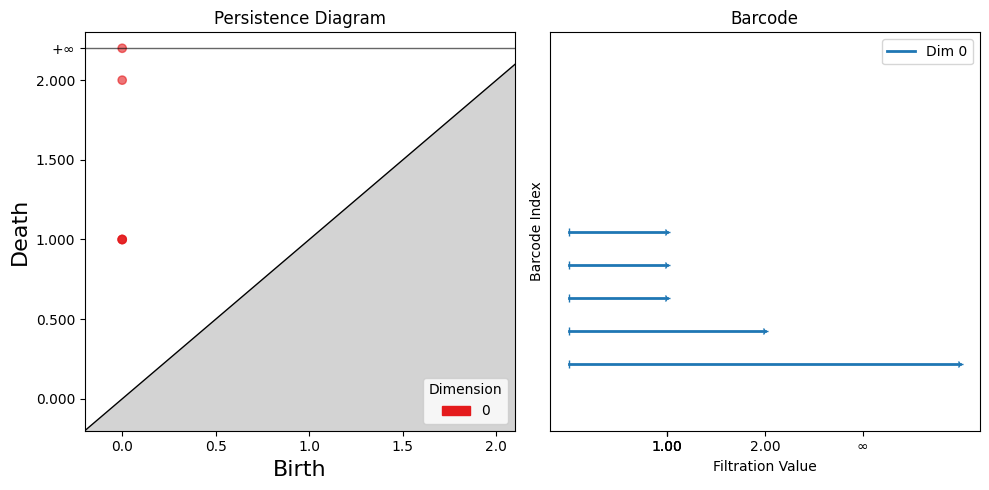

In [4]:
plot_persistence(persistence)

### Ejercicio 3

In [5]:
# Crear el grafo con un ciclo exterior de 6 nodos y un ciclo interior de 3 nodos
cicle_ext = nx.cycle_graph(6)
cicle_int = nx.cycle_graph(3)
cicle_int = nx.relabel_nodes(cicle_int, {i:i+cicle_ext.number_of_nodes() for i in cicle_int.nodes})
G = nx.compose(cicle_ext, cicle_int)

# Aristas adicionales para el plano proyectivo
new_edges = {
    0: [7],
    1: [7, 8],
    2: [8],
    3: [6, 8],
    4: [6],
    5: [6, 7]
}

for src, dst in new_edges.items():
    for d in dst:
        G.add_edge(src, d)

valid_edges = G.edges()

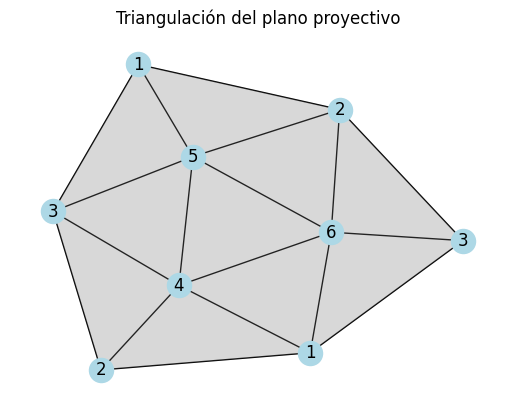

In [6]:
# Plot grafo y fija posiciones
pos = nx.spring_layout(G, seed=3)
fig, ax = plt.subplots()

ids = {
    1: [0, 3],
    2: [1, 4], 
    3: [2, 5],
    4: [6],
    5: [7],
    6: [8]
}
labels = {node: f'{id}' for id, nodes in ids.items() for node in nodes}

nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', labels=labels)

# Encontrar todos los triángulos en el grafo
simplex_3s = [list(triangle) for triangle in nx.enumerate_all_cliques(G) if len(triangle) == 3]
plot_triangles(simplex_3s, ax, pos)

plt.title("Triangulación del plano proyectivo")
plt.show()

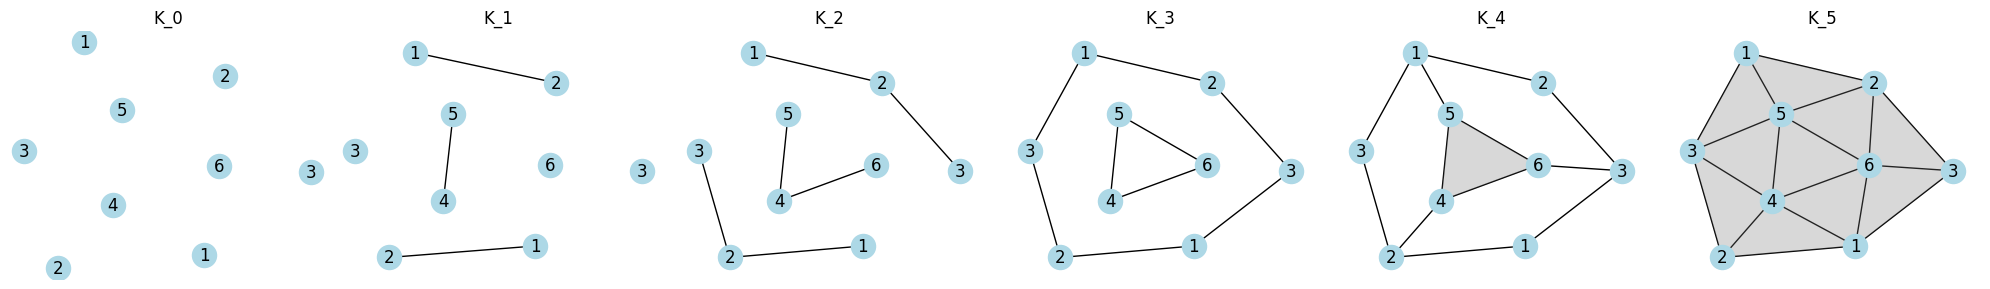

In [32]:
FILTRATION_SIZE = 6
plt.subplots(1, FILTRATION_SIZE, figsize=(20, 3))

G0 = nx.empty_graph(pos.keys())
plt.subplot(1, FILTRATION_SIZE, 1)
nx.draw(G0, pos, labels=labels, with_labels=True, node_color='lightblue')
plt.title('K_0')
plt.tight_layout()

G1 = add_edges_from_ids(G0, ids, [(1,2), (4,5)], valid_edges)
plt.subplot(1, FILTRATION_SIZE, 2)
nx.draw(G1, pos, labels=labels, with_labels=True, node_color='lightblue')
plt.title('K_1')
plt.tight_layout()

G2 = add_edges_from_ids(G1, ids, [(2,3), (4,6)], valid_edges)
plt.subplot(1, FILTRATION_SIZE, 3)
nx.draw(G2, pos, labels=labels, with_labels=True, node_color='lightblue')
plt.title('K_2')
plt.tight_layout()

G3 = add_edges_from_ids(G2, ids, [(3,1), (5,6)], valid_edges)
plt.subplot(1, FILTRATION_SIZE, 4)
nx.draw(G3, pos, labels=labels, with_labels=True, node_color='lightblue')
plt.title('K_3')
plt.tight_layout()

G4 = add_edges_from_ids(G3, ids, [(1,5), (2,4), (3,6)], valid_edges)
plt.subplot(1, FILTRATION_SIZE, 5)
nx.draw(G4, pos, labels=labels, with_labels=True, node_color='lightblue')
plot_triangles([[6, 7, 8]], plt.gca(), pos)
plt.title('K_4')
plt.tight_layout()

plt.subplot(1, FILTRATION_SIZE, 6)
nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightblue') # Grafo completo
simplex_3s = [list(triangle) for triangle in nx.enumerate_all_cliques(G) if len(triangle) == 3]
plot_triangles(simplex_3s, plt.gca(), pos)
plt.title('K_5')
plt.tight_layout()

plt.show()

In [33]:
D = np.array([[0     ,      1, 3, 4, np.inf, np.inf],
              [1     ,      0, 2, 5, np.inf, 5     ],
              [3     ,      2, 0, 5, 5     , 4     ],
              [4     ,      5, 5, 0, 1     , 3     ],
              [np.inf, np.inf, 5, 1, 0     , 2     ],
              [np.inf,      5, 4, 3, 2     , 0     ]])

# 2. Construcción del complejo de Vietoris-Rips con GUDHI
rips_complex = gudhi.RipsComplex(distance_matrix=D, max_edge_length=5.0)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

# 3. Cálculo de la homología persistente
persistence=simplex_tree.persistence()

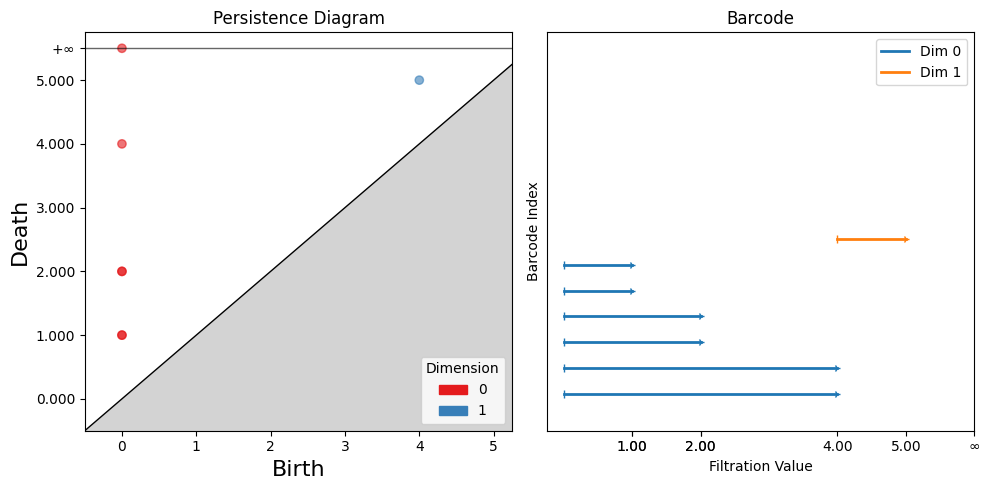

In [34]:
plot_persistence(persistence)